In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbPerfectCode import FiveQbPerfectCodeCircuit
from functions import *


Stabilizers:
    
$$ IZZZZ $$
$$ XXIXZ $$
$$ ZZXXI $$
$$ ZXZIX $$


In [3]:
stabilizers = ['IZZZZ', 'XXIXZ', 'ZZXXI', 'ZXZIX']

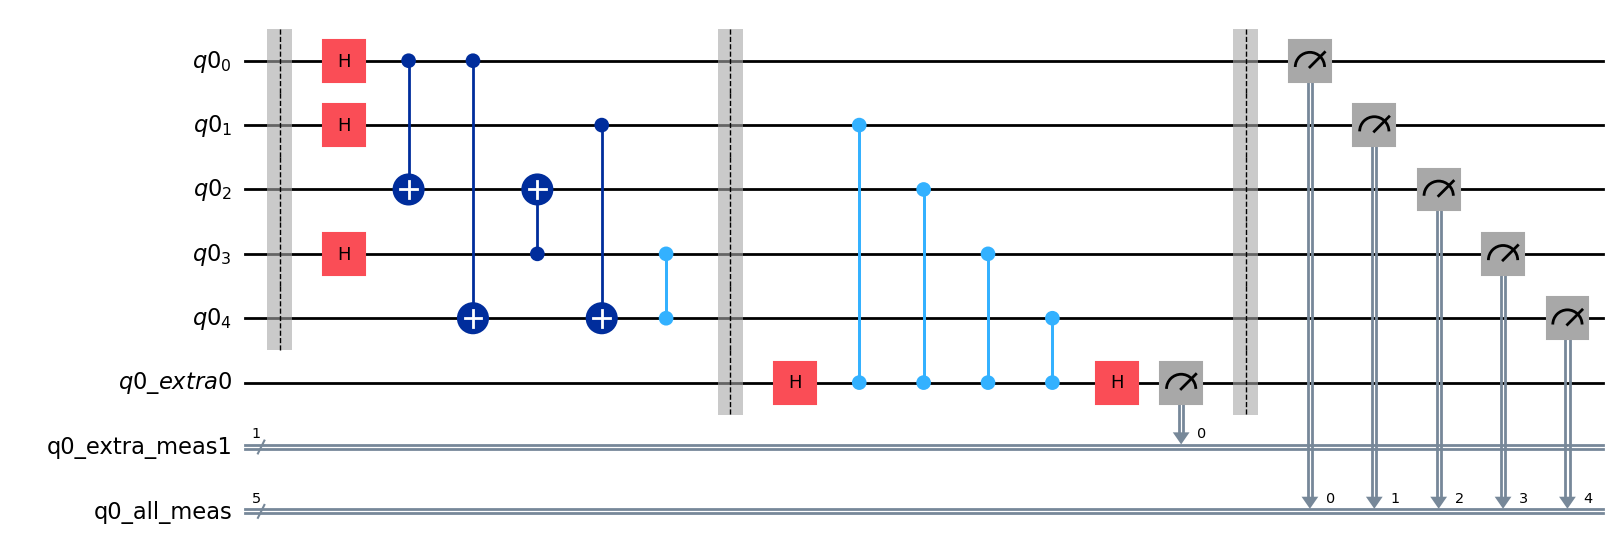

In [ ]:

def load_circuit(stabilizer):

    qc = FiveQbPerfectCodeCircuit(1)

    type = '0'
    qc.encode(type=type)
    
    qc.measure_operator(operator=stabilizer)
    
    # qc.spot_syndrome()
    # qc.measure_syndrome()
    qc.measure_all()

    return qc

qc = load_circuit(stabilizers[0])
qc.draw('mpl')



In [5]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [6]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')



Circuit Depth: 13
Transpiled Circuit Depth: 78


In [7]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [10]:

circuits = []


for s in stabilizers:

    qc = load_circuit(s)

    isa_circuit = get_transpile(qc.physical_circuit, backend, iterations=100)
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {circuits[-1].depth()}")
    print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")
    print(get_layout(circuits[-1], qb_len=6))
    

Circuit Depth: 64
Total Duration: 12.58 us

[77, 78, 71, 76, 79, 91]


C:\Users\marzu\AppData\Local\Temp\ipykernel_50724\565232773.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")


Circuit Depth: 61
Total Duration: 12.58 us

[77, 78, 71, 76, 79, 58]


C:\Users\marzu\AppData\Local\Temp\ipykernel_50724\565232773.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")


Circuit Depth: 65
Total Duration: 12.466 us

[77, 71, 78, 76, 79, 58]


C:\Users\marzu\AppData\Local\Temp\ipykernel_50724\565232773.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")


Circuit Depth: 73
Total Duration: 14.236 us

[77, 78, 71, 76, 79, 58]


C:\Users\marzu\AppData\Local\Temp\ipykernel_50724\565232773.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")


In [8]:
for s in stabilizers:
    simulation_result = sampler_simulation(load_circuit(s).physical_circuit, 3200)

    print(s)

    for lq in qc.qubits:

        state = lq.extra_measures[0]
        # state = lq.all_measures
        print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")

        state = lq.all_measures
        print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")


IZZZZ
  q0_extra_meas1: {'0': 3200}
  q0_all_meas: {'11110': 399, '00000': 390, '00111': 426, '10101': 403, '11001': 365, '01011': 413, '10010': 423, '01100': 381}
XXIXZ
  q0_extra_meas1: {'0': 3200}
  q0_all_meas: {'00000': 421, '01100': 432, '10101': 412, '11001': 357, '10010': 397, '11110': 417, '00111': 367, '01011': 397}
ZZXXI
  q0_extra_meas1: {'0': 3200}
  q0_all_meas: {'00111': 403, '10101': 385, '11001': 396, '01011': 405, '00000': 460, '10010': 393, '11110': 390, '01100': 368}
ZXZIX
  q0_extra_meas1: {'0': 3200}
  q0_all_meas: {'10010': 377, '11110': 389, '00000': 408, '11001': 429, '01011': 432, '01100': 372, '00111': 383, '10101': 410}


In [9]:
sampler = SamplerV2(backend=backend)
shots = 3200

# job = sampler.run(circuits, shots=shots)
job = service.job('cytpske38jq0008xw51g') # sherbrooke


pub_result = job.result()


In [11]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]

results = []
logical_meas_results = []

for i in range(len(stabilizers)):
    result = pub_result[i]
    
    meas = result['__value__']['data']['q0_all_meas'].get_counts()
    res = {}
    for k in states:
        k_inv = k[::-1]
        res[k] = meas[k_inv] if k_inv in meas else 0
        res[k] = res[k] / shots * 100 # %
    results.append(res)

    logical_meas_results.append(result['__value__']['data']['q0_extra_meas1'].get_counts())



TVD (logic measurements)

In [12]:
for i in range(len(stabilizers)):
    print(stabilizers[i])
    print('\t', logical_meas_results[i])
    print(f"\tTVD: {logical_meas_results[i]['1'] / shots*100}%")

IZZZZ
	 {'1': 1320, '0': 1880}
	TVD: 41.25%
XXIXZ
	 {'0': 1797, '1': 1403}
	TVD: 43.84375%
ZZXXI
	 {'0': 1711, '1': 1489}
	TVD: 46.53125%
ZXZIX
	 {'0': 1768, '1': 1432}
	TVD: 44.75%


TVD (final state)

In [13]:

print(f" stabilizer", *[f"{s}" for s in states], sep='\t ')
print("----------------------------------------------------------------------------------")
for i in range(len(stabilizers)):

    # print(f" > {meas}, error rate: {shots - meas['1']}%")
    print(f" {stabilizers[i]}\t", *[round(results[i][s]*shots/100) for s in states], sep='\t ')

 stabilizer	 00000	 00001	 00010	 00011	 00100	 00101	 00110	 00111	 01000	 01001	 01010	 01011	 01100	 01101	 01110	 01111	 10000	 10001	 10010	 10011	 10100	 10101	 10110	 10111	 11000	 11001	 11010	 11011	 11100	 11101	 11110	 11111
----------------------------------------------------------------------------------
 IZZZZ		 169	 57	 52	 50	 34	 26	 355	 132	 47	 83	 23	 49	 16	 27	 109	 331	 38	 77	 126	 381	 77	 125	 36	 62	 89	 31	 278	 136	 91	 27	 39	 27
 XXIXZ		 119	 102	 113	 124	 148	 107	 89	 95	 107	 121	 122	 62	 82	 109	 108	 88	 74	 44	 104	 164	 59	 56	 105	 164	 60	 64	 161	 80	 64	 51	 152	 102
 ZZXXI		 96	 26	 202	 26	 181	 28	 94	 45	 50	 272	 44	 113	 51	 150	 38	 253	 29	 165	 51	 81	 33	 100	 33	 156	 132	 36	 243	 30	 241	 31	 125	 45
 ZXZIX		 145	 88	 91	 114	 49	 46	 111	 168	 88	 161	 84	 64	 47	 52	 177	 86	 77	 143	 178	 90	 64	 76	 151	 74	 117	 75	 100	 180	 73	 45	 66	 120


In [ ]:
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]
alpha = generate_uniform_distribution(5, valid_states)

In [ ]:
tvd = [calculate_tvd(r, alpha, percentage=True) for r in results]

print("stabilizer\tTVD")
print("------------------------")
for i in range(len(stabilizers)):

    print(f"{stabilizers[i]}\t\t", round(tvd[i],3))

stabilizer	TVD
------------------------
IZZZZ		 0.562
XXIXZ		 0.511
ZZXXI		 0.543
ZXZIX		 0.481
